# Metric calculation for the CLM5-PPE (LHC)
- Updated Jan 10, 2023
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os

## spin up some extra cores on CASPER

In [2]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39485 instead
  f"Port {expected} is already in use.\n"


In [3]:
client.cluster

In [65]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][:17]

In [14]:
def get_files(htape,yr0=1850,yr1=2014):
    d='/glade/campaign/asp/djk2120/PPEn11/transient/hist/'

    #find all files
    fs   = np.array(sorted(glob.glob(d+'*'+htape+'*')))
    yrs  = np.array([int(f.split(htape)[1][1:5]) for f in fs])
    keys = np.array([f.split('.clm2')[0][-7:] for f in fs])
    
    #bump back yr0, if needed
    uyrs=np.unique(yrs)
    yr0=uyrs[(uyrs/yr0)<=1][-1]
    
    #find index to subset files
    ix   = (yrs>=yr0)&(yrs<=yr1)
    yrs  = yrs[ix]
    keys = keys[ix]

    #subset and reshape files
    ny=np.sum(keys=='LHC0000')
    nens = int(len(keys)/ny)
    files = fs[ix].reshape([nens,ny])

    #convert to list of lists
    files = [list(f) for f in files]
    
    return files,np.unique(keys)

In [5]:
def add_params(ds,df,keys):
    mems=df['member'].values
    ix1=0*mems==1
    for key in keys:
        ix1=(ix1)|(mems==key)

    nens=len(ds.ens)    
    ix2=0*np.arange(nens)==1
    for mem in mems:
        ix2=(ix2)|(ds.key==mem)


    params=[]    
    for p in df.keys():
        if p!='member':
            x=xr.DataArray(np.nan+np.zeros(nens),dims='ens')
            x[ix2]=df[p][ix1]
            ds[p]=x
            params.append(p)
    ds['params']=xr.DataArray(params,dims='param')

In [10]:
def get_ds(dvs,htape,yr0=1850,yr1=2014,dropdef=False):
    
    def preprocess(ds):
        return ds[dvs]
    
    #read in the data
    files,keys = get_files(htape,yr0,yr1)
    if dropdef:
        files = files[1:]
        keys  = keys[1:]
    
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                       parallel=True,preprocess=preprocess)
    
    #fix the time dimension, if needed
    yr0=str(ds['time.year'].values[0])
    if (htape=='h0')|(htape=='h1'):
        ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS',calendar='noleap')
    
    #add some param info, etc.
    df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt')
    ds['key']=xr.DataArray(keys,dims=['ens'])
    add_params(ds,df,keys)
    
    #add landarea info
    la_file = '/glade/u/home/djk2120/clm5ppe/pyth/sparsegrid_landarea.nc'
    la = xr.open_dataset(la_file).landarea  #km2
    ds['la'] = la
    
    #add some extra variables, e.g. lat/lon
    tmp = xr.open_dataset(files[0][0])
    for v in tmp.data_vars:
        if 'time' not in tmp[v].dims:
            if v not in ds:
                ds[v]=tmp[v]
                
    if htape=='h1':
        ds['pft']=ds.pfts1d_itype_veg
    
    return ds
    

In [53]:
def gmean(da,la,cf=1):
    #global mean
    xg=cf/la.sum()*(la*da).sum(dim='gridcell').compute()
    return xg
whit = xr.open_dataset('./whit/whitkey.nc')
def bmean(da,la):
    g=whit.biome
    xb=1/la.groupby(g).sum()*(la*da).groupby(g).sum(dim='gridcell').compute()
    xb['biome_name']=xr.DataArray(whit.biome_name.values,dims='biome')
    return xb
def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa
def pmean(da,la):
    xp=(1/la.groupby('pft').sum()*(da*la).groupby('pft').sum()).compute()
    return xp

In [8]:
def write_metric(da,v,m,ln='',units='',years=''):
    f='./processed_data/metrics/'+v+'.nc'
    if glob.glob(f):
        dsout = xr.open_dataset('./processed_data/metrics/TLAI.nc')
        if m in dsout:
            if dsout[m].equals(da)==0:
                raise Exception(m+" already exists in "+f+", and does not match input DataArray")
            else:
                update=False
        else:
            update=True
    else:
        dsout=xr.Dataset()
        update=True
    if update:
        dsout[m]=da
        dsout[m].attrs={'long_name':ln,'units':units,'years':years}
        if glob.glob(f):
            dsout.to_netcdf(f+'.tmp')
            os.system('mv '+f+'.tmp '+f)
        else:
            dsout.to_netcdf(f)

# metrics
 - global avg LAI (2005-2014)
 - biome avg LAI (2005-2014)
 - LAI TREND (1985-2014?)

In [21]:
dvs=['TLAI']
htape='h1'
yr0=2003
yr1=2014
ds=get_ds(dvs,htape,yr0=yr0,yr1=yr1)

In [57]:
t=slice(str(yr0),str(yr1))
da=ds.TLAI.sel(time=t)
la=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t)
lai=amean(pmean(da,la)).mean(dim='year')

In [64]:
v='TLAI'
m='TLAI_pft_avg_2003'
ln='PFT average LAI'
years=str(yr0)+'-'+str(yr1)
units=ds[v].attrs['units']
write_metric(lai,v,m,ln=ln,units=units,years=years)

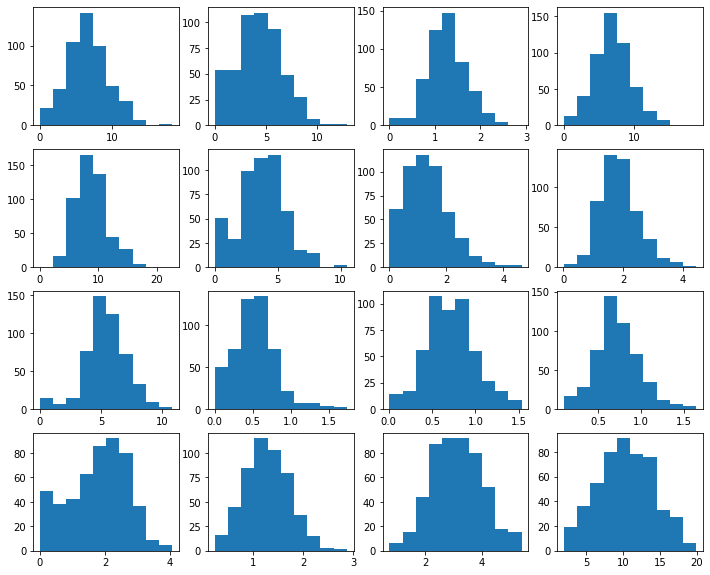

In [68]:
plt.figure(figsize=[12,10])
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.hist(lai.sel(pft=i))

### global and biome level avg TLAI, 2005-2014

In [14]:
dvs=['TLAI']
htape='h0'
yr0=2005
yr1=2014
ds2005=get_ds(dvs,htape,yr0=yr0,yr1=yr1)

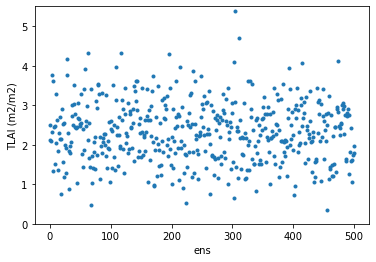

In [16]:
#calculate global LAI
v='TLAI'
tlai_global_2005=gmean(amean(ds2005[v]).mean(dim='year'),ds2005.la)

#write to netcdf
m='TLAI_global_avg_2010'
ln='Global average LAI'
years=str(yr0)+'-'+str(yr1)
units=ds2005.TLAI.attrs['units']
write_metric(tlai_global_2005,v,m,ln=ln,units=units,years=years)

#plot
tlai_global_2005.plot.line('.')
plt.ylabel(v+' (m2/m2)')
plt.ylim([0,5.5]);

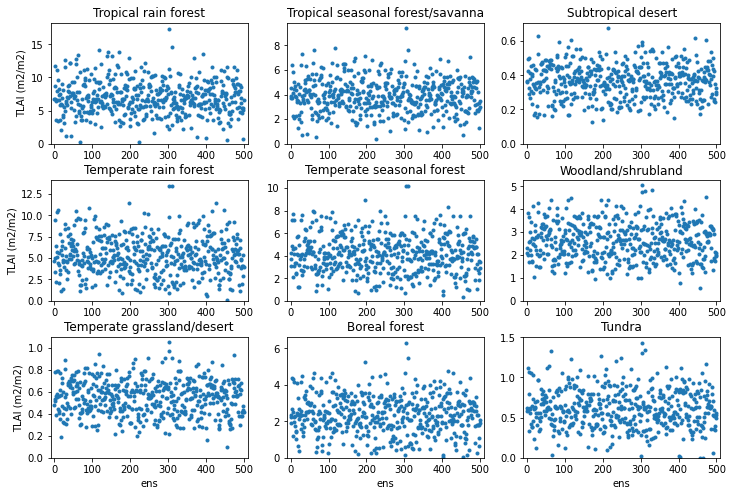

In [19]:
#calculate biome-level LAI
v='TLAI'
x=bmean(amean(ds2005[v]).mean(dim='year'),ds2005.la)

#write to netcdf
m='TLAI_biome_avg_2010'
ln='Biome average LAI'
years=str(yr0)+'-'+str(yr1)
units=ds2005.TLAI.attrs['units']
write_metric(x,v,m,ln=ln,units=units,years=years)

#plot
plt.figure(figsize=[12,8])
for i in 1+np.arange(9):
    plt.subplot(3,3,i)
    x.isel(biome=i).plot.line('.')
    plt.title(x.biome_name[i].values)
    plt.ylim(bottom=0)
    plt.xlim([-10,510])
    if i%3==1:
        plt.ylabel('TLAI (m2/m2)')
    if i<=6:
        plt.xlabel('')
plt.subplots_adjust(hspace=0.3)

### 40 year global LAI trend

In [20]:
dvs=['TLAI']
htape='h0'
yr0=1975
yr1=2014
ds1975=get_ds(dvs,htape,yr0=yr0,yr1=yr1)

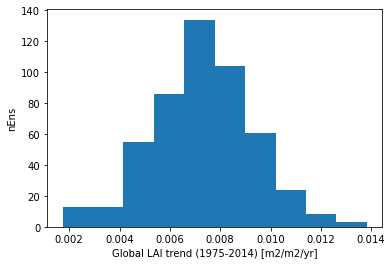

In [25]:
#calculate global LAI trend (1975-2014)
v='TLAI'
lai_ann=gmean(amean(ds1975[v]),ds1975.la)
coefs=lai_ann.polyfit(dim='year',deg=1).compute()
x=coefs.polyfit_coefficients.sel(degree=1)

#write to netcdf
m='TLAI_global_trend_1975'
ln='Global LAI trend'
years=str(yr0)+'-'+str(yr1)
units="m2/m2/yr"
write_metric(x,v,m,ln=ln,units=units,years=years)

#plot
plt.hist(x)
plt.ylabel('nEns')
plt.xlabel(ln+' ('+years+') ['+units+']');

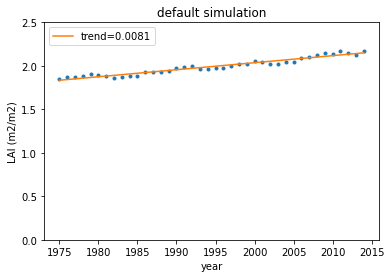

In [26]:
ee=0
lai_ann.isel(ens=ee).plot.line('.')
x=lai_ann.year
m,b=coefs.polyfit_coefficients.isel(ens=ee).values
plt.plot(x,m*x+b,label='trend='+str(np.round(m,4)))
plt.ylabel('LAI (m2/m2)')
plt.title('default simulation')
plt.ylim([0,2.5])
plt.legend(loc=2);

### compare to yes-leap

In [27]:
ds1=xr.open_dataset('./processed_data/metrics/TLAI_bad_leap.nc')
ds2=xr.open_dataset('./processed_data/metrics/TLAI.nc')

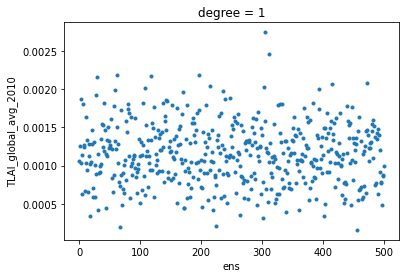

In [30]:
(ds1.TLAI_global_avg_2010-ds2.TLAI_global_avg_2010).plot.line('.')